In [1]:
# Imports
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import os
import hashlib
import requests
from matplotlib import pyplot as plt
import tqdm as tqdm

In [2]:
# Variables for file and download URL
fname = "condsForSimJ2moMuscles.mat"  # The name of the file to be downloaded
url = "https://osf.io/wak7e/download" # URL from where the file will be downloaded
expected_md5 = "257d16c4d92759d615bf5cac75dd9a1f" # MD5 hash for verifying file integrity

# Check if the file already exists
if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [3]:
import numpy as np
import torch
import scipy.io

# Load the .mat file
data = scipy.io.loadmat('condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

# Initialize lists to store data for all conditions
go_envelope_all = []
plan_all = []
muscle_all = []

# Get the number of conditions (rows) and delay durations (columns)
num_conditions, num_delays = conds_for_sim.shape

# Loop through each condition and extract data
for i in range(num_conditions):  # 27 conditions
    go_envelope_condition = []
    plan_condition = []
    muscle_condition = []

    for j in range(num_delays):  # 8 delay durations
        condition = conds_for_sim[i, j]

        go_envelope = condition['goEnvelope']
        plan = condition['plan']
        muscle = condition['muscle']

        # Select only muscles 5 and 6 
        selected_muscle_data = muscle[:, [3, 4]]  # which show the nicest multiphasic activity

        go_envelope_condition.append(go_envelope)
        plan_condition.append(plan)
        muscle_condition.append(selected_muscle_data)

    # Convert lists of NumPy arrays to single NumPy arrays before conversion to tensors
    go_envelope_np = np.array(go_envelope_condition)
    plan_np = np.array(plan_condition)
    muscle_np = np.array(muscle_condition)

    # Convert the single NumPy arrays to PyTorch tensors
    go_envelope_all.append(torch.tensor(go_envelope_np, dtype=torch.float32))
    plan_all.append(torch.tensor(plan_np, dtype=torch.float32))
    muscle_all.append(torch.tensor(muscle_np, dtype=torch.float32))

# Stack data for all conditions
go_envelope_tensor = torch.stack(go_envelope_all)
plan_tensor = torch.stack(plan_all)
muscle_tensor = torch.stack(muscle_all)

# Print the shapes to confirm
print(f'Go Envelope Tensor: {go_envelope_tensor.shape}')
print(f'Plan Tensor: {plan_tensor.shape}')
print(f'Muscle Tensor: {muscle_tensor.shape}')

# Clean up
del data, conds_for_sim, go_envelope_all, plan_all, muscle_all
import gc
gc.collect()


Go Envelope Tensor: torch.Size([27, 8, 296, 1])
Plan Tensor: torch.Size([27, 8, 296, 15])
Muscle Tensor: torch.Size([27, 8, 296, 2])


0

shape of normalised inputs torch.Size([27, 8, 296, 16])


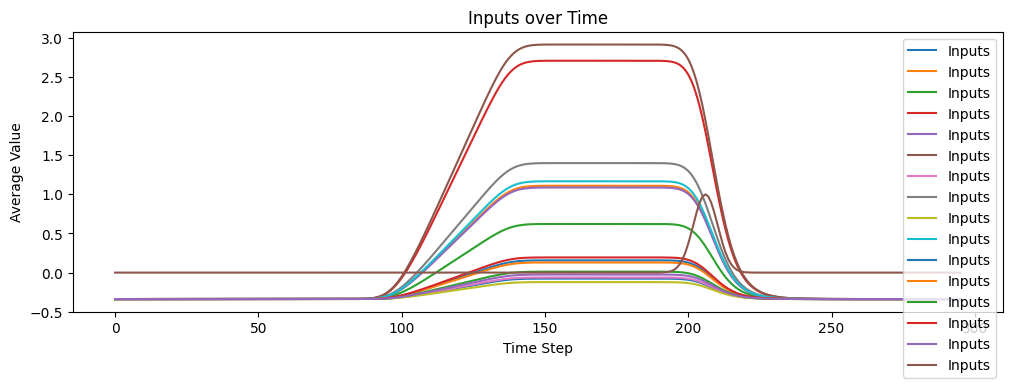

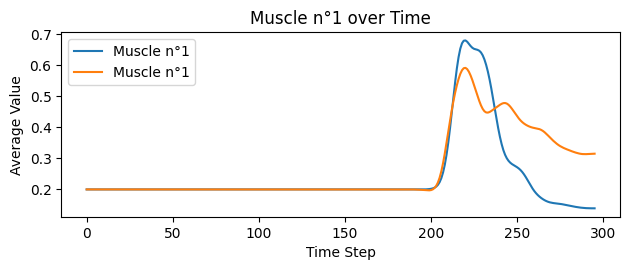

In [4]:
# Normalization and Standardization Function
def normalize_and_standardize(tensor):
    # Normalize
    min_val = tensor.min()
    max_val = tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)    
    # Standardize
    mean = tensor.mean()
    std = tensor.std()
    standardized_normalized_tensor = (tensor - mean) / std
    return standardized_normalized_tensor

plan_tensor = normalize_and_standardize(plan_tensor)

# Concatenate Plan and Go Envelope Tensors
normalised_inputs = torch.cat([plan_tensor, go_envelope_tensor], dim=3)  # Resulting shape: [27, 8, 296, 16]

print("shape of normalised inputs", normalised_inputs.shape)

# Averaging across conditions and delays
avg_inputs = normalised_inputs.mean(dim=[0, 1]).squeeze()
avg_output = muscle_tensor.mean(dim=[0, 1])

# For plan and muscle
# individual features for plotting 
feature_idx = 7 #max14
muscle_idx = 1 #max1

# Time steps
timesteps = np.arange(296)

# Plotting Go Envelope
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(timesteps, avg_inputs, label='Inputs')
plt.title('Inputs over Time')
plt.xlabel('Time Step')
plt.ylabel('Average Value')
plt.legend()
plt.show()
# Plotting Muscle Feature
plt.subplot(2, 1, 2)
plt.plot(timesteps, avg_output, label=f'Muscle n°{muscle_idx}')
plt.title(f'Muscle n°{muscle_idx} over Time')
plt.xlabel('Time Step')
plt.ylabel('Average Value')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
class ComplicatedTimeseriesDataset(Dataset):
    def __init__(self, inputs, targets, delay_idx):
        """
        inputs: Tensor of shape [27, 8, 296, input_features]
        targets: Tensor of shape [27, 8, 296, output_features]
        delay_idx: Fixed index of the delay to be used
        """
        self.inputs = inputs[:, delay_idx]
        self.targets = targets[:, delay_idx]
        self.num_conditions = inputs.shape[0]

        print("Shape of inputs - ComplicatedRNN", self.inputs.shape)
        print("Shape of targets - ComplicatedRNN", self.targets.shape)

    def __len__(self):
        return self.num_conditions

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq

# Choose the delay index
fixed_delay_idx = 3

# Create the dataset with the fixed delay
complicated_dataset = ComplicatedTimeseriesDataset(normalised_inputs, muscle_tensor, fixed_delay_idx)

# Split the dataset
train_size = int(0.6 * len(complicated_dataset))
val_size = int(0.2 * len(complicated_dataset))
test_size = len(complicated_dataset) - train_size - val_size

complicated_train_dataset, complicated_val_dataset, complicated_test_dataset = random_split(complicated_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 1
complicated_train_loader = DataLoader(complicated_train_dataset, batch_size=batch_size, shuffle=True)
complicated_val_loader = DataLoader(complicated_val_dataset, batch_size=batch_size, shuffle=False)
complicated_test_loader = DataLoader(complicated_test_dataset, batch_size=batch_size, shuffle=False)


Shape of inputs - ComplicatedRNN torch.Size([27, 296, 16])
Shape of targets - ComplicatedRNN torch.Size([27, 296, 2])


In [6]:
# Flatten the first two dimensions (conditions and delays)
flattened_inputs = normalised_inputs.view(-1, *normalised_inputs.shape[2:])
flattened_targets = muscle_tensor.view(-1, *muscle_tensor.shape[2:])

class SimpleTimeseriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        
        print("Shape of inputs - SimpleRNN", self.inputs.shape)
        print("Shape of targets - SimpleRNN", self.targets.shape)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq

# Create the SimpleRNN dataset
simple_dataset = SimpleTimeseriesDataset(flattened_inputs, flattened_targets)

# Split the dataset
simple_train_size = int(0.6 * len(simple_dataset))
simple_val_size = int(0.2 * len(simple_dataset))
simple_test_size = len(simple_dataset) - simple_train_size - simple_val_size

simple_train_dataset, simple_val_dataset, simple_test_dataset = random_split(simple_dataset, [simple_train_size, simple_val_size, simple_test_size])

batch_size = 31

# Create DataLoaders
simple_train_loader = DataLoader(simple_train_dataset, batch_size=batch_size, shuffle=True)
simple_val_loader = DataLoader(simple_val_dataset, batch_size=batch_size, shuffle=False)
simple_test_loader = DataLoader(simple_test_dataset, batch_size=batch_size, shuffle=False)


Shape of inputs - SimpleRNN torch.Size([216, 296, 16])
Shape of targets - SimpleRNN torch.Size([216, 296, 2])


In [7]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' 
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' 
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    return avg_test_loss


torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([5, 296, 16])
Epoch 1, Training Loss: 0.13218719884753227
Epoch 1, Validation Loss: 0.003342456300742924
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([5, 296, 16])
Epoch 2, Training Loss: 0.08917402252554893
Epoch 2, Validation Loss: 0.0014966073213145137
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([5, 296, 16])
Epoch 3, Training Loss: 0.08475391045212746
Epoch 3, Validation Loss: 0.0013323005987331271
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([5, 296, 16])
Epoch 4, Training Loss: 0.0805128313601017
Epoch 4, Validation Loss: 0.0011535544763319194
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([31, 296, 16])
torch.Size([5,

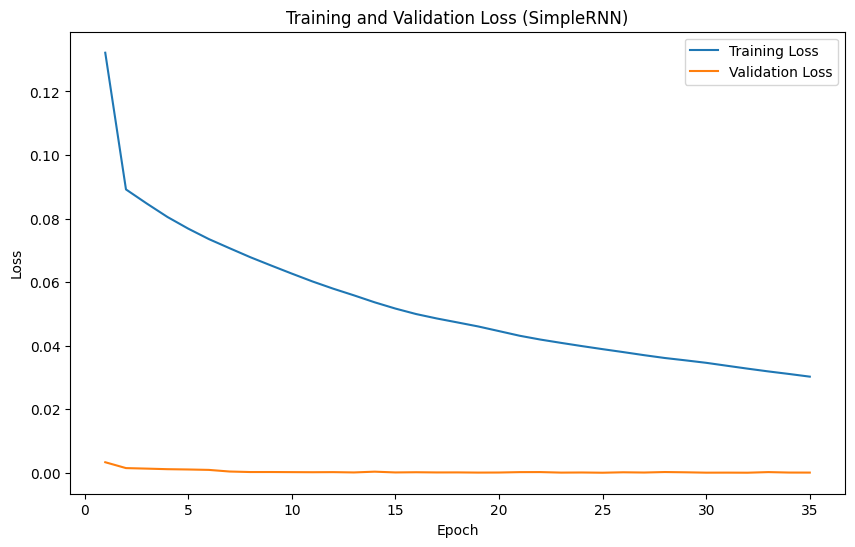

In [8]:
from torch.cuda.amp import autocast, GradScaler
from torch.autograd import profiler

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh 
         
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration    
        # Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1)) 
        input_update = torch.matmul(self.B, x.transpose(0, 1))        
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)    
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)    
        # Output calculation
        output = self.output_linear(firing_rate)    
        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum()
        dynamic_reg = torch.linalg.norm(torch.matmul(self.J, grad_rectified_tanh(hidden.transpose(0, 1))), ord='fro', dim=(-2, -1)).sum()
 
        return output, hidden, firing_rate_reg, dynamic_reg

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg

# Hyperparameters
input_size = 16 # Features + Go Cue
hidden_size = 150
output_size = 2  # Number of muscles
g = 1.5  # g value
h_val = 1.0  # h value

# Hyperparameters for regularization
alpha = 1e-4  
beta = 0.03
gamma = 1e-4

# Training Loop
num_epochs = 200
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Model instantiation
model = SimpleRNN(input_size, hidden_size, output_size, g, h_val)
model.to(device)

# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0) ### WD=0. Note: Paper uses Hessian-Free optimizer
scaler = GradScaler()

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode

    # Initialize hidden states 
    hidden_states_for_plot = []

    for inputs, targets in simple_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        print(inputs.shape)
        h = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad() 

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        with autocast():  # Enable automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
                hidden_states_for_plot.append(h.detach().cpu().numpy())
                total_firing_rate_reg += firing_rate_reg
                total_dynamic_reg += dynamic_reg

            # Compute loss and regularization terms
            loss = criterion(output, targets[:, -1, :])
            l2_reg = compute_l2_regularization(model.parameters(), alpha)
            rfr_reg = beta * total_firing_rate_reg / inputs.shape[1] / hidden_size / num_conditions
            rj_reg = gamma * total_dynamic_reg / inputs.shape[1] / num_conditions
            total_loss = loss + l2_reg + rfr_reg + rj_reg

        scaler.scale(total_loss).backward()  # Scale loss and perform backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        scaler.step(optimizer)  # Update optimizer
        scaler.update()  # Update scaler

        running_loss += total_loss.item()

    avg_loss = running_loss / len(simple_train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(model, simple_val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(model, simple_test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device.type == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_num_epochs + 1), epoch_losses, label='Training Loss')
plt.plot(range(1, actual_num_epochs + 1), val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (SimpleRNN)')
plt.legend()
plt.show()


Epoch 1, Training Loss: 0.022905118194103125
Epoch 1, Validation Loss: 0.005536525137722492
Epoch 2, Training Loss: 0.004821632539915299
Epoch 2, Validation Loss: 0.001872904459014535
Epoch 3, Training Loss: 0.002979681657961919
Epoch 3, Validation Loss: 0.0017969707030715653
Epoch 4, Training Loss: 0.0015787335486265874
Epoch 4, Validation Loss: 0.0014279950846685097
Epoch 5, Training Loss: 0.0024971825650936808
Epoch 5, Validation Loss: 0.0014713411685079337
Epoch 6, Training Loss: 0.0021687981961804326
Epoch 6, Validation Loss: 0.0012911293073557318
Epoch 7, Training Loss: 0.0011242318275890284
Epoch 7, Validation Loss: 0.0030751698766835036
Epoch 8, Training Loss: 0.0011880274363704757
Epoch 8, Validation Loss: 0.003535317772912094
Epoch 9, Training Loss: 0.0015004693286755355
Epoch 9, Validation Loss: 0.0023826661985367537
Epoch 10, Training Loss: 0.0013822780929331202
Epoch 10, Validation Loss: 0.001633871567901224
Epoch 11, Training Loss: 0.0011508625661917904
Epoch 11, Validati

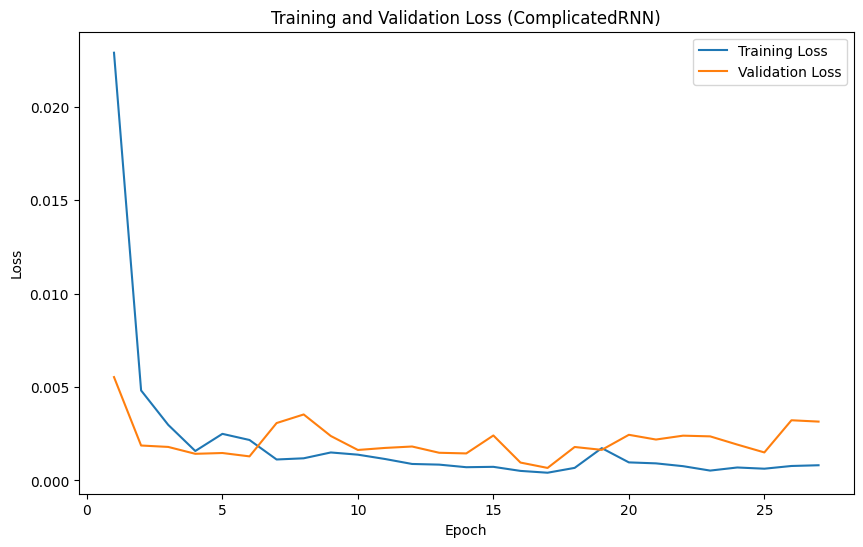

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2

# ComplicatedRNN class
class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Weight initialization (unchanged)
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity (unchanged)
        self.nonlinearity = rectified_tanh 
        

    def forward(self, x, hidden):
        # Forward pass logic (same as SimpleRNN but without regularization terms)
        hidden_prev = hidden.clone()
        timestep = self.tau / 10
        #Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1))
        input_update = torch.matmul(self.B, x.transpose(0, 1))     
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)
        output = self.output_linear(firing_rate)
        
        return output, hidden
        
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

# Training loop
# Hyperparameters
input_size = 16
hidden_size = 150
output_size = 2  # Number of muscles
g = 4  # g value
h_val = 1.0  # h value

# Training Loop
num_epochs = 300
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Model instantiation
complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h_val)
complicated_model.to(device)

# Loss function and optimizer (no weight decay)
criterion = nn.MSELoss()
optimizer = optim.Adam(complicated_model.parameters(), lr=0.001, weight_decay=0)
scaler = GradScaler()

# Training loop 
for epoch in range(num_epochs):
    running_loss = 0.0
    hidden_states_for_plot_cm = []

    complicated_model.train()  # Set the model to training mode
    for inputs, targets in complicated_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = complicated_model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()

        with autocast():  # Apply automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h = complicated_model(inputs[:, t, :], h)
                hidden_states_for_plot_cm.append(h.detach().cpu().numpy())

            loss = criterion(output, targets[:, -1, :])

        scaler.scale(loss).backward()  # Scale loss for backward pass
        scaler.step(optimizer)  # Update optimizer with scaled gradients
        scaler.update()  # Update the scaler

        running_loss += loss.item()

    avg_loss = running_loss / len(complicated_train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(complicated_model, complicated_val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(complicated_model, complicated_test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device.type == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_num_epochs + 1), epoch_losses, label='Training Loss')
plt.plot(range(1, actual_num_epochs + 1), val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ComplicatedRNN)')
plt.legend()
plt.show()

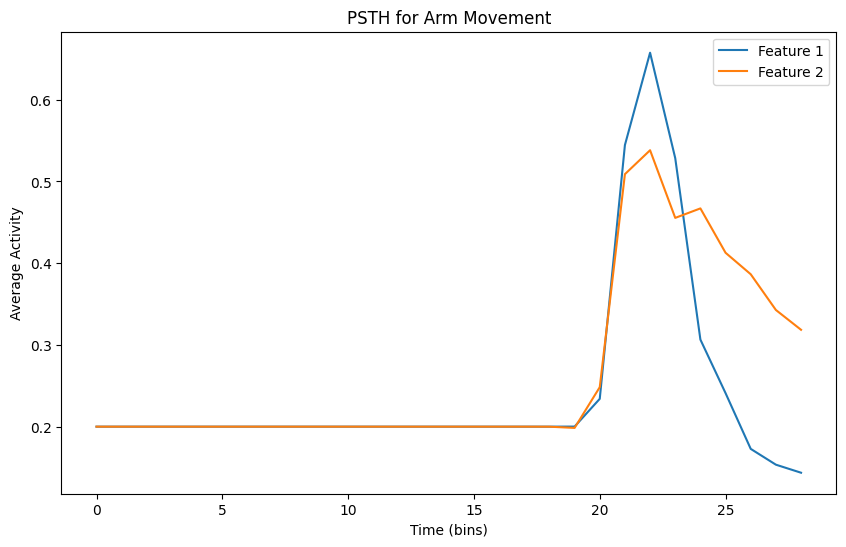

In [11]:
import matplotlib.pyplot as plt
import torch

def plot_psth(data, title, bin_size=10):
    """
    Plot Peri-Stimulus Time Histogram (PSTH) for given data.
    :param data: a tensor containing the neural data of shape [conditions, delays, time, features]
    :param title: a string for the plot title
    :param bin_size: size of time bins for averaging
    """
    # Averaging neural activity across conditions, delays for each time bin
    mean_data = data.mean(dim=(0, 1))  # Mean across conditions and delays

    # Number of bins
    n_bins = mean_data.shape[0] // bin_size

    # Prepare the data for plotting
    binned_data = mean_data[:n_bins*bin_size].unfold(0, bin_size, bin_size).mean(dim=2)

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(binned_data.shape[1]):  # Iterate over each feature/channel
        plt.plot(binned_data[:, i], label=f'Feature {i+1}')
    plt.xlabel('Time (bins)')
    plt.ylabel('Average Activity')
    plt.title(title)
    plt.legend()
    plt.show()

plot_psth(muscle_tensor, "PSTH for Arm Movement")


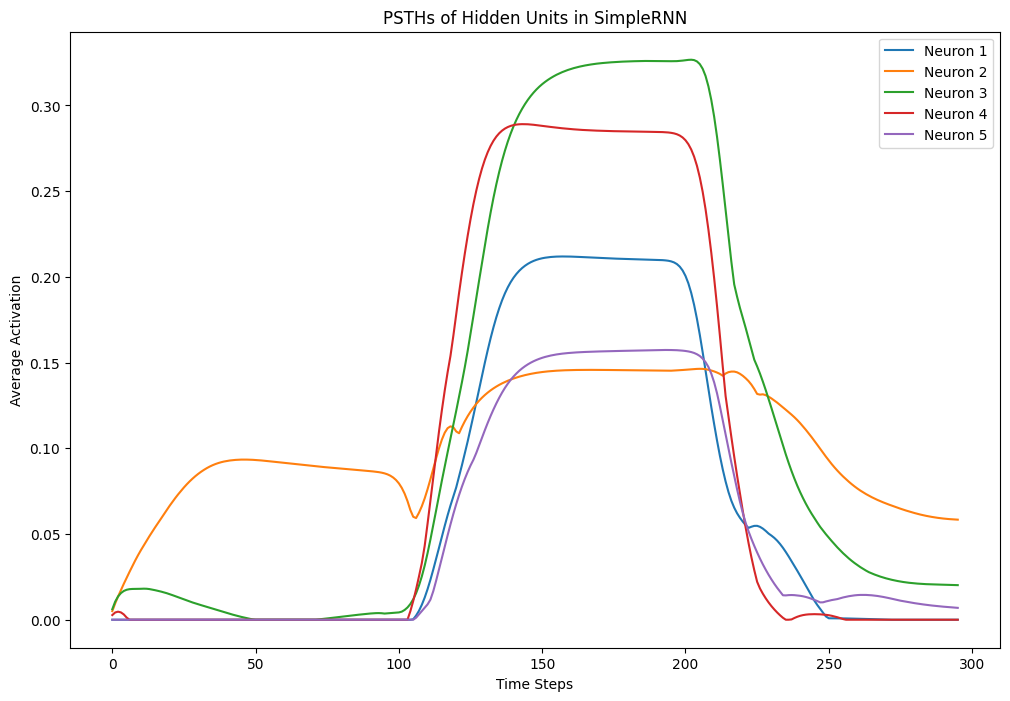

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Slicing to take only the last 296 timesteps
last_hidden_states = hidden_states_for_plot[-296:]

# Apply the nonlinearity to each hidden state before averaging
rectified_tanh = lambda x: np.where(x > 0, np.tanh(x), 0)
hidden_states = rectified_tanh(np.array(last_hidden_states))

# Calculate the mean across all batches for each time step
mean_activations = np.mean(hidden_states, axis=1)

# Plot the PSTHs for the first few neurons
neurons_to_plot = 5  
time_steps = mean_activations.shape[0]
plt.figure(figsize=(12, 8))

for i in range(min(neurons_to_plot, hidden_states.shape[2])):
    plt.plot(range(time_steps), mean_activations[:, i], label=f'Neuron {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Activation')
plt.title('PSTHs of Hidden Units in SimpleRNN')
plt.legend()
plt.show()


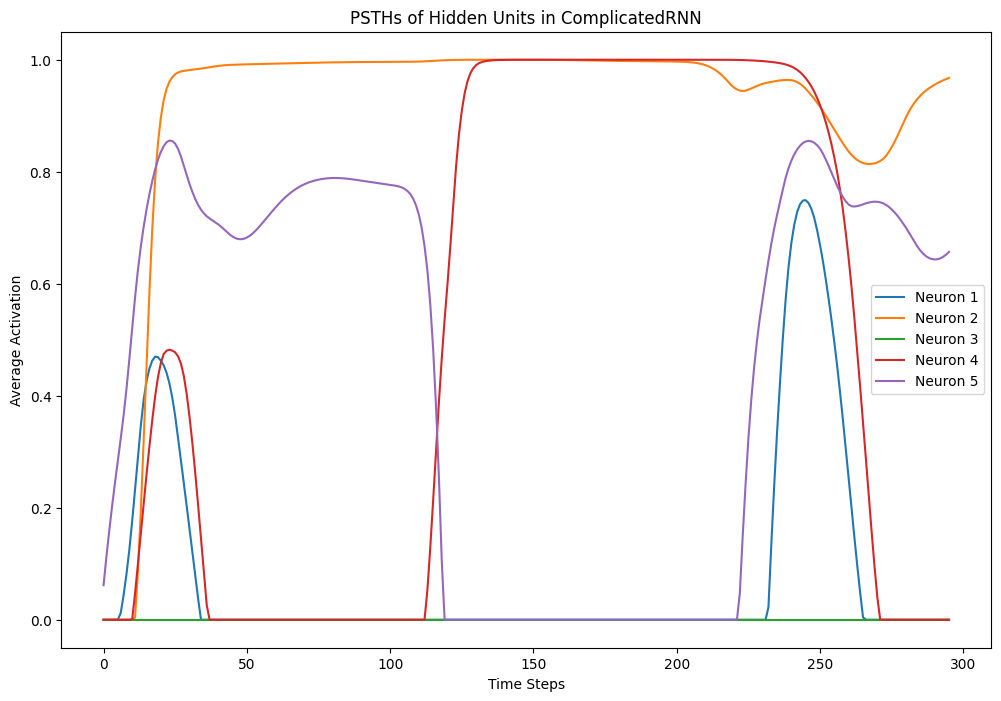

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Slicing to take only the last 296 timesteps
last_hidden_states = hidden_states_for_plot_cm[-296:]

# Apply the nonlinearity to each hidden state before averaging
rectified_tanh = lambda x: np.where(x > 0, np.tanh(x), 0)
hidden_states = rectified_tanh(np.array(last_hidden_states))

# Calculate the mean across all batches for each time step
mean_activations = np.mean(hidden_states, axis=1)

# Plot the PSTHs for the first few neurons
neurons_to_plot = 5  
time_steps = mean_activations.shape[0]
plt.figure(figsize=(12, 8))

for i in range(min(neurons_to_plot, hidden_states.shape[2])):
    plt.plot(range(time_steps), mean_activations[:, i], label=f'Neuron {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Activation')
plt.title('PSTHs of Hidden Units in ComplicatedRNN')
plt.legend()
plt.show()


Perturbation strength: 0.0001, Mean Error Difference: 1.455657184123993e-07, Model: SimpleRNN(
  (output_linear): Linear(in_features=150, out_features=2, bias=True)
)
Perturbation strength: 0.001, Mean Error Difference: 2.167932689189911e-06, Model: SimpleRNN(
  (output_linear): Linear(in_features=150, out_features=2, bias=True)
)
Perturbation strength: 0.01, Mean Error Difference: 2.176119014620781e-05, Model: SimpleRNN(
  (output_linear): Linear(in_features=150, out_features=2, bias=True)
)
Perturbation strength: 0.1, Mean Error Difference: 0.0002244871109724045, Model: SimpleRNN(
  (output_linear): Linear(in_features=150, out_features=2, bias=True)
)
Perturbation strength: 1, Mean Error Difference: 0.0060730335302650925, Model: SimpleRNN(
  (output_linear): Linear(in_features=150, out_features=2, bias=True)
)
Perturbation strength: 10, Mean Error Difference: 0.04899022039026022, Model: SimpleRNN(
  (output_linear): Linear(in_features=150, out_features=2, bias=True)
)
Perturbation st

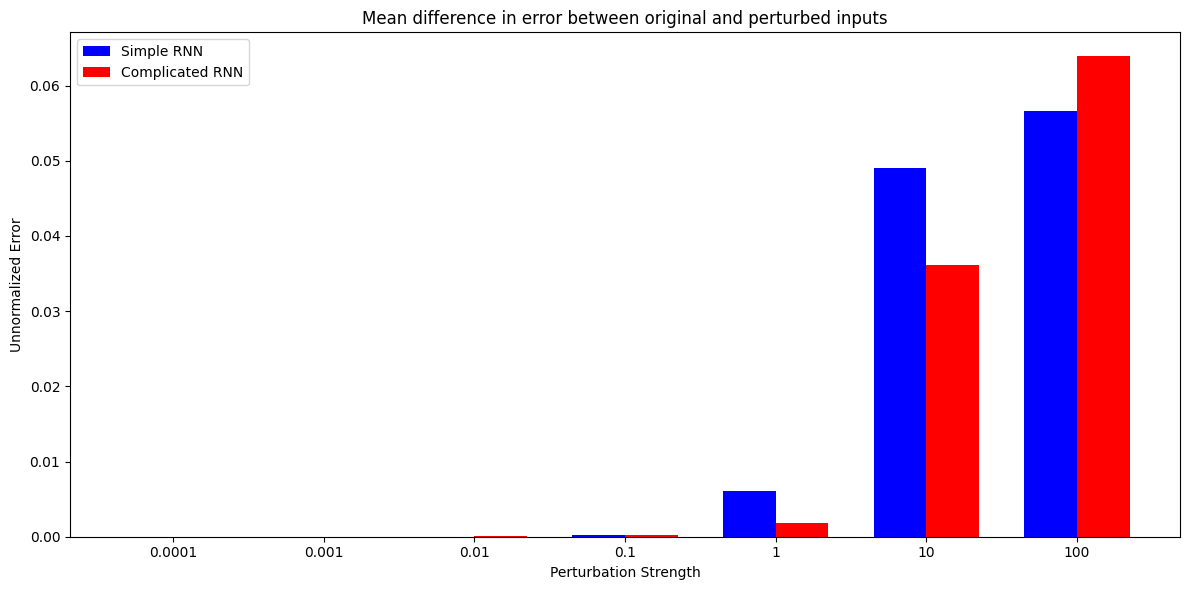

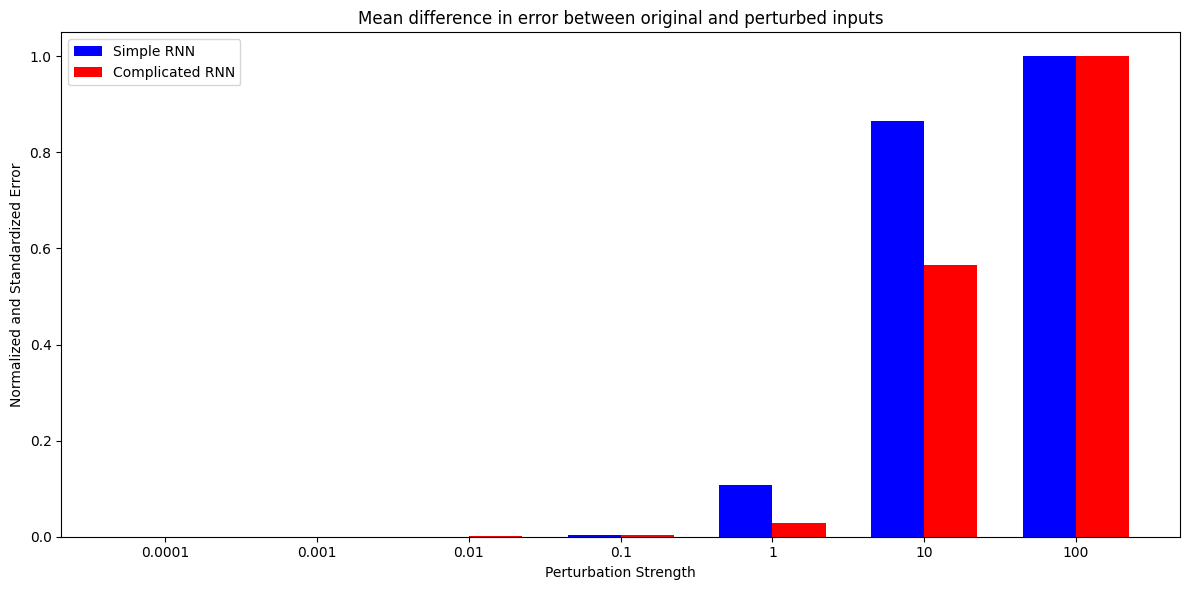

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def perturb_inputs(model, inputs, perturbation_strength):
    # Perturb the inputs by adding random noise scaled by the perturbation strength
    noise = torch.randn_like(inputs) * perturbation_strength
    perturbed_inputs = inputs + noise
    return perturbed_inputs

def compute_loss(model, inputs, targets, criterion, device):
    batch_size = inputs.size(0)
    h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
    for t in range(inputs.shape[1]):  # Iterate over time steps
        model_output = model(inputs[:, t, :], h)
        output, h, *rest = model_output
    # Compute loss for the entire sequence 
    mean_targets = torch.mean(targets, dim=1)
    loss = criterion(output, mean_targets).item()
    return loss

def test_perturbed_inputs(model, perturbation_strengths, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    perturbation_errors_diffs = []

    for strength in perturbation_strengths:
        batch_errors_diffs = []  # Store differences in errors for each batch in the test_loader
        
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Compute error for original inputs
            original_loss = compute_loss(model, inputs, targets, criterion, device)
            
            # Compute error for perturbed inputs
            perturbed_inputs = perturb_inputs(model, inputs, strength)
            perturbed_loss = compute_loss(model, perturbed_inputs, targets, criterion, device)
            
            # Calculate the difference in errors and store it
            error_diff = abs(perturbed_loss - original_loss)
            batch_errors_diffs.append(error_diff)
        
        mean_error_diff = np.mean(batch_errors_diffs)  # Calculate mean difference in error for this perturbation strength
        perturbation_errors_diffs.append(mean_error_diff)
        print(f'Perturbation strength: {strength}, Mean Error Difference: {mean_error_diff}, Model: {model}')
    
    return perturbation_errors_diffs

perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
simple_model_errors = test_perturbed_inputs(model, perturbation_strengths, simple_train_loader, criterion, device)
complex_model_errors = test_perturbed_inputs(complicated_model, perturbation_strengths, complicated_train_loader, criterion, device)

print("simple model errors", simple_model_errors)
print("complex model errors", complex_model_errors)

# Set the width of the bars
bar_width = 0.35  # Adjust this as needed

# Create an array of indices for the x-axis ticks
x_indices = np.arange(len(perturbation_strengths))

# Plotting
plt.figure(figsize=(12, 6))

# Plot bars for the simple model
plt.bar(x_indices - bar_width/2, simple_model_errors, width=bar_width, color='blue', label='Simple RNN')

# Plot bars for the complex model
plt.bar(x_indices + bar_width/2, complex_model_errors, width=bar_width, color='red', label='Complicated RNN')

# Labeling and aesthetics
plt.xlabel('Perturbation Strength')
plt.ylabel('Unnormalized Error')
plt.title('Mean difference in error between original and perturbed inputs')

# Set custom tick positions and labels on the x-axis
plt.xticks(x_indices, perturbation_strengths)

plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the mean and standard deviation of simple_model_errors
simple_mean = np.mean(simple_model_errors)
simple_std = np.std(simple_model_errors)

# Normalize and standardize simple_model_errors
normalized_simple_errors = (simple_model_errors - np.min(simple_model_errors)) / (np.max(simple_model_errors) - np.min(simple_model_errors))
standardized_simple_errors = (simple_model_errors - simple_mean) / simple_std

# Calculate the mean and standard deviation of complex_model_errors
complex_mean = np.mean(complex_model_errors)
complex_std = np.std(complex_model_errors)

# Normalize and standardize complex_model_errors
normalized_complex_errors = (complex_model_errors - np.min(complex_model_errors)) / (np.max(complex_model_errors) - np.min(complex_model_errors))
standardized_complex_errors = (complex_model_errors - complex_mean) / complex_std

# Plotting
plt.figure(figsize=(12, 6))

# Plot bars for the simple model
plt.bar(x_indices - bar_width/2, normalized_simple_errors, width=bar_width, color='blue', label='Simple RNN')

# Plot bars for the complex model
plt.bar(x_indices + bar_width/2, normalized_complex_errors, width=bar_width, color='red', label='Complicated RNN')

# Labeling and aesthetics
plt.xlabel('Perturbation Strength')
plt.ylabel('Normalized and Standardized Error')
plt.title('Mean difference in error between original and perturbed inputs')

# Set custom tick positions and labels on the x-axis
plt.xticks(x_indices, perturbation_strengths)

plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader

def perturb_recurrent_weights(model, perturbation_strength):
    # Perturb the recurrent weight matrix J by adding Gaussian noise
    with torch.no_grad():
        noise = torch.randn_like(model.J) * perturbation_strength
        perturbed_weights = model.J + noise
        return perturbed_weights

def test_perturbed_structure(model, perturbation_strengths, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    perturbation_errors = []
    original_weights = model.J.data.clone()  # Save the original weights

    for strength in perturbation_strengths:
        batch_errors = []  # Store errors for each batch in the test_loader
        # Perturb the recurrent weights of the model
        perturbed_weights = perturb_recurrent_weights(model, strength)
        model.J.data = perturbed_weights.data

        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
            
            for t in range(inputs.shape[1]):  # Iterate over time steps
                model_output = model(inputs[:, t, :], h)
                if len(model_output) == 4:  # If the model returns 4 outputs, unpack all (simple model)
                    output, h, _, _ = model_output
                else:  # If the model returns 2 outputs, unpack accordingly (complicated model)
                    output, h = model_output
            
            # Compute loss for the entire sequence (last output)
            loss = criterion(output, targets[:, -1, :]).item()
            batch_errors.append(loss)  # Append the loss of this batch
        
        # Restore the original weights before the next iteration
        model.J.data = original_weights.data
        
        mean_error = np.mean(batch_errors)  # Calculate mean error for this perturbation strength
        perturbation_errors.append(mean_error)
        print(f'Perturbation strength: {strength}, Mean Error: {mean_error}')
    
    return perturbation_errors

# Define perturbation strengths
perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

# Get errors for simple and complex models
simple_model_structural_errors = test_perturbed_structure(model, perturbation_strengths, simple_train_loader, criterion, device)
complex_model_structural_errors = test_perturbed_structure(complicated_model, perturbation_strengths, complicated_train_loader, criterion, device)

# Normalize the errors by dividing by the maximum error in each group
max_simple_error = max(simple_model_structural_errors)
max_complex_error = max(complex_model_structural_errors)
simple_model_normalized_errors = [error / max_simple_error for error in simple_model_structural_errors]
complex_model_normalized_errors = [error / max_complex_error for error in complex_model_structural_errors]

# Calculate the mean and standard deviation of simple_model_normalized_errors
simple_normalized_mean = np.mean(simple_model_normalized_errors)
simple_normalized_std = np.std(simple_model_normalized_errors)

# Calculate the mean and standard deviation of complex_model_normalized_errors
complex_normalized_mean = np.mean(complex_model_normalized_errors)
complex_normalized_std = np.std(complex_model_normalized_errors)

# Standardize simple_model_normalized_errors
standardized_simple_normalized_errors = [(error - simple_normalized_mean) / simple_normalized_std for error in simple_model_normalized_errors]

# Standardize complex_model_normalized_errors
standardized_complex_normalized_errors = [(error - complex_normalized_mean) / complex_normalized_std for error in complex_model_normalized_errors]

# Set the width of the bars
bar_width = 0.35  # Adjust this as needed

# Create an array of indices for the x-axis ticks
x_indices = np.arange(len(perturbation_strengths))

# Plotting
plt.figure(figsize=(8, 6))  # Adjust the figure size

# Plot bars for the simple model
plt.bar(x_indices - bar_width/2, simple_model_normalized_errors, width=bar_width, color='blue', label='Simple RNN')

# Plot bars for the complex model
plt.bar(x_indices + bar_width/2, complex_model_normalized_errors, width=bar_width, color='red', label='Complicated RNN')

# Labeling 
plt.xlabel('Perturbation Strength (log scale)')
plt.ylabel('Normalized Error')
plt.title('Perturbation test of the weights')

# Set custom tick positions and labels on the x-axis
plt.xticks(x_indices, perturbation_strengths)

plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
